<a href="https://colab.research.google.com/github/mearan/Eficiendet/blob/main/Roboflow_EfficientDet_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For the most up to date version of this notebook, please copy from this link


---



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1ZmbeTro4SqT7h_TfW63MLdqbrCUk_1br#scrollTo=KwDS9qqBbMQa)




# Overview

💡 Recommendation: Open this blog post on [how to train EfficientDet](https://towardsdatascience.com/training-efficientdet-object-detection-model-with-a-custom-dataset-25fb0f190555) to continue.

In this notebook we show an example of how to train EfficientDet using a pytorch implementation on a custom dataset that has been uploaded through RoboFlow. The example provides a flexible framework, so you can apply it to your own dataset with a custom number of classes and a different objective. We we tackle chess here. 

![Chess Example](https://i.imgur.com/nkjobw1.png)

### **Our Data and Roboflow**

Our dataset of 289 chess images (and 2894 annotations!) is hosted publicly on Roboflow [here](https://public.roboflow.ai/object-detection/chess-full). Roboflow also hosts many other public datasets and you can easily upload your own custom dataset for your use case, augment, and export in flexible formats. Our tutorial uses Coco Json, but you might have another format (say tfrecord). No problem! Upload your dataset and we will export it in the required format.

### **Model and Training**

For a deep dive on the EfficientDet model please see [the paper](https://arxiv.org/abs/1911.09070). For a shorter look, here is a great [blog post](https://towardsdatascience.com/efficientdet-scalable-and-efficient-object-detection-review-4472ffc34fd9)! 

We use a pytorch implementation of EfficientDet using the [image detection library](https://github.com/roboflow-ai/Monk_Object_Detection) from Tessellate-Imaging for object detection. Our implementation uses the base version of EfficientDet-d0.  We train from the EfficientNet base backbone, without using a pretrained checkpoint for the detector.

### **Inference**

We witness some fast inference on a few basic examples from our test set to see that our approach is heading in the right direction.

### **Export**

We export our model weights to google drive for future utilization.

### **Next Steps**

We will be exploring evaluation on custom RoboFlow datasets and objectives compared to yoloV3, including training time, inference time, model size, and performance. 

We will also explore comparing performance from the Coco pretrained checkpoint!

## **Stay in touch!**

If you run into any hurdles on your own data set or just want to share some cool results in your own domain, [reach out to us](roboflow.ai)! 

#### ![Roboflow Workmark](https://i.imgur.com/WHFqYSJ.png)



# Setting up our envionment

In [2]:
#our fork of the Tessellate-Imaging image detection library
#!rm -rf Monk_Object_Detection
! git clone https://github.com/roboflow-ai/Monk_Object_Detection.git

Cloning into 'Monk_Object_Detection'...
remote: Enumerating objects: 3794, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 3794 (delta 28), reused 30 (delta 16), pack-reused 3747
Receiving objects: 100% (3794/3794), 132.21 MiB | 21.94 MiB/s, done.
Resolving deltas: 100% (828/828), done.
Updating files: 100% (4032/4032), done.


In [3]:
# For colab use the command below
# Set up library requirments
! cd Monk_Object_Detection/3_mxrcnn/installation && cat requirements_colab.txt | xargs -n 1 -L 1 pip install

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.0/354.0 MB 3.8 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/abhi-kumar/cocoapi.git to /tmp/pip-install-4rqqa0gi/pycocotools_4b812fcd2eea4a459a208cc6765af935
  Running command git clone --filter=blob:none --quiet https://github.com/abhi-kumar/cocoapi.git /tmp/pip-install-4rqqa0gi/pycocotools_4b812fcd2eea4a459a208cc6765af935
  Resolved https://github.com/abhi-kumar/cocoapi.git to commit 1d6

In [4]:
#fixed version of tqdm output for Colab
!pip install --force https://github.com/chengs/tqdm/archive/colab.zip
#IGNORE restart runtime warning, it is indeed installed
#missing a few extra packages that we will need later! 
!pip install efficientnet_pytorch
!pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     - 91.8 kB 5.8 MB/s 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for tqdm: filename=tqdm-4.28.1-py2.py3-none-any.whl size=47876 sha256=b66d2e20b9839e27d3a1343300347fc729ff861af0ae9bcfa9d928f2d3a745cf
  Stored in directory: /tmp/pip-ephem-wheel-cache-dnx6o1ey/wheels/65/77/d5/d5ddeac9924f01d101ed3d2bf420c627eba535f8b8d93f27ee
Successfully built tqdm
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.65.0
    Uninstalling tqdm-4.65.0:
      Successfully uninstalled tqdm-4.65.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
panel 0.14.4 requires tqdm>=4.48.0, but you have tqdm 4.28.1 which is incompatible.
prophet 1.1.2 requires tqdm>=4.36.1, but you have tqdm 4.28.1 which is incompatible.
spacy 3.5.2 requires tqdm<5.0.0,>=4.

# Let's get some data! 

The best part about Roboflow is the efficient management of your datasets. [Upload you dataset](roboflow.ai) and you will recieve a fresh curl code to ouput it in whatever augmented and annotated format you need. 

In [6]:
!curl -L "https://app.roboflow.com/ds/CEUgj3HBPt?key=4NvpPvx249" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip


Streaming output truncated to the last 5000 lines.
 extracting: train/2010-mitsubishi-fuso-26-ft-box-truck_jpg.rf.61f5c54cdbd4130986dca6211ad29956.jpg  
 extracting: train/2010-mitsubishi-fuso-26-ft-box-truck_jpg.rf.ad87da9c93b2c74fb0ea8fa893f8055d.jpg  
 extracting: train/2010-mitsubishi-fuso-fe145-12ft-box-_jpg.rf.45421b6754ea04223df4c22a75140490.jpg  
 extracting: train/2010-mitsubishi-fuso-fe145-12ft-box-_jpg.rf.a4b78d6af27baebd48e2e7b3df92f9c9.jpg  
 extracting: train/2010-mitsubishi-fuso-fe145-12ft-box-_jpg.rf.b2672a85bcd8512d6b2c960db59e0572.jpg  
 extracting: train/2010-mitsubishi-fuso-fe145-12ft-box-_jpg.rf.dbf8827d740d345375d6d525c0bd6b08.jpg  
 extracting: train/2012-mitsubishi-fuso-canter-fe160-du-1_jpg.rf.0fdef5168f9bf62c805932e31a13fc4b.jpg  
 extracting: train/2012-mitsubishi-fuso-canter-fe160-du-1_jpg.rf.221f67b1c1d2d34498253f1f2c7fdafc.jpg  
 extracting: train/2012-mitsubishi-fuso-canter-fe160-du-1_jpg.rf.5f6727824f063ce642c7d5e098e307cf.jpg  
 extracting: train/2012-m

In [ ]:
#fresh curl courtesy of roboflow.ai, outputing our dataset in Coco Json format

!curl -L [YOUR-LINK-HERE] > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   888  100   888    0     0   1385      0 --:--:-- --:--:-- --:--:--  1385
100 78.6M  100 78.6M    0     0  50.7M      0  0:00:01  0:00:01 --:--:--  111M
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/0b47311f426ff926578c9d738d683e76_jpg.rf.0b55f43ac16aa65c889558d8ea757072.jpg  
 extracting: test/1c0060ef868bdc326ce5e6389cb6732f_jpg.rf.9ce88078ea356949f4ab7ad9cfdfc62d.jpg  
 extracting: test/2f6fb003bb89cd401322a535acb42f65_jpg.rf.91ad9df05bd1f86bab67c8368ae5e4ad.jpg  
 extracting: test/410993714e325a1de3e394ffe860df3a_jpg.rf.519bf0fdbd5e38cd44cae1cfebc98536.jpg  
 extracting: test/4e3117459d759798537eb52cf5bf534d_jpg.rf.5b99421bf416463a8c75cfd07f8a68d1.jpg  
 extracting: test/5a35ba2ec3e0d0b2b12b1758a8ac29aa_jpg.rf.a907af85301c729635d6ab1

In [7]:
#let's take a look at our directory
#notice the data came down in train, valid, test, splits - this is pre set during the dataset upload process
%ls

Monk_Object_Detection/  README.roboflow.txt  test/   valid/
README.dataset.txt      sample_data/         train/


In [8]:
#let's take a peak in train
#jpg images and some coco json annotations
%ls train

0000147617-e4eb190337827f8bbbcc9317d-1_jpg.rf.1f9e5ec14aa27345b7997db3764c90e4.jpg
0000147617-e4eb190337827f8bbbcc9317d-1_jpg.rf.2a7484bd2b0b636f518e38d3f65dbc66.jpg
0000147617-e4eb190337827f8bbbcc9317d-1_jpg.rf.3d8042e54db73460b229cbac7b0d4eaf.jpg
0000147617-e4eb190337827f8bbbcc9317d-1_jpg.rf.53512efb311e6ad82dfb3ba5956904a3.jpg
0000147617-e4eb190337827f8bbbcc9317d-1_jpg.rf.5a1bf7c5fab4aee519ae7bab6c355862.jpg
0000147617-e4eb190337827f8bbbcc9317d_jpg.rf.339066048621cbee362d66a73a60681f.jpg
0000147617-e4eb190337827f8bbbcc9317d_jpg.rf.619f670367ea014370dbf790ed4d54cf.jpg
0000147617-e4eb190337827f8bbbcc9317d_jpg.rf.6776d9b59d7f761781f100061dd3b75d.jpg
0000147617-e4eb190337827f8bbbcc9317d_jpg.rf.8c43c881f65a44f2778e12bf834ecf60.jpg
0000161190-eff4a7d6440628a6ed58e9d9a_jpg.rf.14bc640dcfdecb2e7a1e146f14a77b88.jpg
0000161190-eff4a7d6440628a6ed58e9d9a_jpg.rf.1d8308d28f9977c018a8cb71e8a868da.jpg
0000161190-eff4a7d6440628a6ed58e9d9a_jpg.rf.93caefb47f9c7574d516d45f32dd4399.jpg
0000161190-eff4a7d

In [28]:
#in the next three cells, we move the data into a structure that the image detection library will be expecting
#but no file data manipulation is necessary
#images can also be segmented into class folders, but we combine all classes here
!mkdir Chess
!mkdir Chess/annotations
!mkdir Chess/Annotations
!mkdir Chess/Images

In [9]:
!mkdir Kendaraan
!mkdir Kendaraan/annotations
!mkdir Kendaraan/Annotations
!mkdir Kendaraan/Images

In [29]:
%cp train/_annotations.coco.json Chess/annotations/instances_Images.json

In [30]:
%cp train/*.jpg Chess/Images/

# Training

In this section we set up the efficientDet-d0 model from backbone and train to our custom case

In [32]:
import os
import sys
sys.path.append("Monk_Object_Detection/4_efficientdet/lib/");

In [33]:
from train_detector import Detector

In [34]:
gtf = Detector();

In [35]:
#directs the model towards file structure
root_dir = "./";
coco_dir = "Chess";
img_dir = "./";
set_dir = "Images";

In [36]:
#smells like some free compute from Colab, nice
gtf.Train_Dataset(root_dir, coco_dir, img_dir, set_dir, batch_size=8, image_size=640, use_gpu=True)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [37]:
gtf.Model();

Loaded pretrained weights for efficientnet-b0


In [38]:
gtf.Set_Hyperparams(lr=0.0001, val_interval=1, es_min_delta=0.0, es_patience=0)

In [42]:
%%time
gtf.Train(num_epochs=26, model_output_dir="trained/");

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

faild onnx export


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

faild onnx export


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

faild onnx export


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

faild onnx export


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

faild onnx export


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

faild onnx export


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

faild onnx export


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

faild onnx export


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

faild onnx export


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

faild onnx export


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

faild onnx export


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

faild onnx export


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

faild onnx export


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

faild onnx export


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

faild onnx export


CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 14.75 GiB total capacity; 13.58 GiB already allocated; 8.81 MiB free; 13.68 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 14.75 GiB total capacity; 13.59 GiB already allocated; 8.81 MiB free; 13.68 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 14.75 GiB total capacity; 13.59 GiB already allocated; 8.81 MiB free; 13.68 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
CUDA ou

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

faild onnx export


CUDA out of memory. Tried to allocate 22.00 MiB (GPU 0; 14.75 GiB total capacity; 13.53 GiB already allocated; 14.81 MiB free; 13.67 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 14.75 GiB total capacity; 13.48 GiB already allocated; 14.81 MiB free; 13.67 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 14.75 GiB total capacity; 13.48 GiB already allocated; 14.81 MiB free; 13.67 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
CUDA

CUDA out of memory. Tried to allocate 30.00 MiB (GPU 0; 14.75 GiB total capacity; 13.50 GiB already allocated; 22.81 MiB free; 13.66 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
CUDA out of memory. Tried to allocate 72.00 MiB (GPU 0; 14.75 GiB total capacity; 13.13 GiB already allocated; 22.81 MiB free; 13.66 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
CUDA out of memory. Tried to allocate 72.00 MiB (GPU 0; 14.75 GiB total capacity; 13.13 GiB already allocated; 22.81 MiB free; 13.66 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
CUDA

CUDA out of memory. Tried to allocate 72.00 MiB (GPU 0; 14.75 GiB total capacity; 13.48 GiB already allocated; 48.81 MiB free; 13.64 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
CUDA out of memory. Tried to allocate 72.00 MiB (GPU 0; 14.75 GiB total capacity; 13.25 GiB already allocated; 48.81 MiB free; 13.64 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
CUDA out of memory. Tried to allocate 72.00 MiB (GPU 0; 14.75 GiB total capacity; 13.25 GiB already allocated; 48.81 MiB free; 13.64 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
CUDA

CUDA out of memory. Tried to allocate 72.00 MiB (GPU 0; 14.75 GiB total capacity; 13.46 GiB already allocated; 12.81 MiB free; 13.67 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
CUDA out of memory. Tried to allocate 72.00 MiB (GPU 0; 14.75 GiB total capacity; 13.46 GiB already allocated; 12.81 MiB free; 13.67 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
CUDA out of memory. Tried to allocate 72.00 MiB (GPU 0; 14.75 GiB total capacity; 13.46 GiB already allocated; 12.81 MiB free; 13.67 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
CUDA

CUDA out of memory. Tried to allocate 194.00 MiB (GPU 0; 14.75 GiB total capacity; 13.53 GiB already allocated; 36.81 MiB free; 13.65 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
CUDA out of memory. Tried to allocate 192.00 MiB (GPU 0; 14.75 GiB total capacity; 13.34 GiB already allocated; 102.81 MiB free; 13.58 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
CUDA out of memory. Tried to allocate 192.00 MiB (GPU 0; 14.75 GiB total capacity; 13.34 GiB already allocated; 102.81 MiB free; 13.58 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

CUDA out of memory. Tried to allocate 192.00 MiB (GPU 0; 14.75 GiB total capacity; 13.39 GiB already allocated; 62.81 MiB free; 13.62 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
CUDA out of memory. Tried to allocate 192.00 MiB (GPU 0; 14.75 GiB total capacity; 13.39 GiB already allocated; 62.81 MiB free; 13.62 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
CUDA out of memory. Tried to allocate 192.00 MiB (GPU 0; 14.75 GiB total capacity; 13.39 GiB already allocated; 62.81 MiB free; 13.62 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
C

CUDA out of memory. Tried to allocate 66.00 MiB (GPU 0; 14.75 GiB total capacity; 13.50 GiB already allocated; 22.81 MiB free; 13.66 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
CUDA out of memory. Tried to allocate 66.00 MiB (GPU 0; 14.75 GiB total capacity; 13.50 GiB already allocated; 22.81 MiB free; 13.66 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
CUDA out of memory. Tried to allocate 66.00 MiB (GPU 0; 14.75 GiB total capacity; 13.50 GiB already allocated; 22.81 MiB free; 13.66 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
CUDA

CUDA out of memory. Tried to allocate 66.00 MiB (GPU 0; 14.75 GiB total capacity; 13.50 GiB already allocated; 22.81 MiB free; 13.66 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
CUDA out of memory. Tried to allocate 66.00 MiB (GPU 0; 14.75 GiB total capacity; 13.50 GiB already allocated; 22.81 MiB free; 13.66 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
CUDA out of memory. Tried to allocate 66.00 MiB (GPU 0; 14.75 GiB total capacity; 13.50 GiB already allocated; 22.81 MiB free; 13.66 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
CUDA

CUDA out of memory. Tried to allocate 66.00 MiB (GPU 0; 14.75 GiB total capacity; 13.50 GiB already allocated; 22.81 MiB free; 13.66 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
CUDA out of memory. Tried to allocate 66.00 MiB (GPU 0; 14.75 GiB total capacity; 13.50 GiB already allocated; 22.81 MiB free; 13.66 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
CUDA out of memory. Tried to allocate 66.00 MiB (GPU 0; 14.75 GiB total capacity; 13.50 GiB already allocated; 22.81 MiB free; 13.66 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
CUDA

CUDA out of memory. Tried to allocate 66.00 MiB (GPU 0; 14.75 GiB total capacity; 13.50 GiB already allocated; 22.81 MiB free; 13.66 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
CUDA out of memory. Tried to allocate 66.00 MiB (GPU 0; 14.75 GiB total capacity; 13.50 GiB already allocated; 22.81 MiB free; 13.66 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
CUDA out of memory. Tried to allocate 66.00 MiB (GPU 0; 14.75 GiB total capacity; 13.50 GiB already allocated; 22.81 MiB free; 13.66 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
CUDA

# Inference

In [43]:
import os
import sys
sys.path.append("Monk_Object_Detection/4_efficientdet/lib/");

In [44]:
from infer_detector import Infer

In [45]:
gtf = Infer();

In [46]:
#our trained model weights are in here in onxx format
gtf.Model(model_dir="trained/")

In [47]:
#extract class list from our annotations
import json
with open('train/_annotations.coco.json') as json_file:
    data = json.load(json_file)
class_list = []
for category in data['categories']:
  class_list.append(category['name'])

In [48]:
class_list

['Deteksi', 'Bus', 'car', 'motorcycle', 'plat', 'truck']

In [49]:
%%time
test_images = [f for f in os.listdir('test') if f.endswith('.jpg')]
import random
img_path = "test/" + random.choice(test_images);
duration, scores, labels, boxes = gtf.Predict(img_path, class_list, vis_threshold=0.2);

Done. (0.168s)
NO Object Detected


TypeError: ignored

In [50]:
from IPython.display import Image
Image(filename='output.jpg') 

FileNotFoundError: ignored

# Export Trained Weights

In [ ]:
#export trained model
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%mkdir trained_export
%cp ./trained/signatrix_efficientdet_coco.onnx ./trained_export/signatrix_efficientdet_coco_$(date +%F-%H:%M).onnx
%cp ./trained/signatrix_efficientdet_coco.pth ./trained_export/signatrix_efficientdet_coco_$(date +%F-%H:%M).pth
%mv ./trained_export/* /content/drive/My\ Drive/

# Reloading Trained Weights after Export

Imagine you have exported your trained model and would like to reaccess it later. This portion of the notebook picks up the trained model and starts at inference


In [ ]:
#export trained model
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#our fork of the Tessellate-Imaging image detection library
#!rm -rf Monk_Object_Detection
! git clone https://github.com/roboflow-ai/Monk_Object_Detection.git

In [ ]:
# For colab use the command below
# Set up library requirments
! cd Monk_Object_Detection/3_mxrcnn/installation && cat requirements_colab.txt | xargs -n 1 -L 1 pip install

#fixed version of tqdm output for Colab
!pip install --force https://github.com/chengs/tqdm/archive/colab.zip
#IGNORE restart runtime warning, it is indeed installed
#missing a few extra packages that we will need later! 
!pip install efficientnet_pytorch
!pip install tensorboardX

In [ ]:
#recover trained weights
!mkdir '/trained'
!cp '/content/drive/MyDrive/signatrix_efficientdet_coco_2021-03-22-02:02.onnx' '/trained/signatrix_efficientdet_coco.onnx'
!cp '/content/drive/MyDrive/signatrix_efficientdet_coco_2021-03-22-02:02.pth' '/trained/signatrix_efficientdet_coco.pth'

In [ ]:
import os
import sys
sys.path.append("Monk_Object_Detection/4_efficientdet/lib/");

In [ ]:
from infer_detector import Infer
gtf = Infer();

In [ ]:
#our trained model weights are in here in onxx format
gtf.Model(model_dir="/trained")

In [ ]:
#download some test data
!curl -L [YOUR LINK HERE] | jar -x

curl: (3) [globbing] bad range in column 2
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0curl: (6) Could not resolve host: LINK
curl: (3) [globbing] unmatched close brace/bracket in column 5


In [ ]:
!ls test

0b47311f426ff926578c9d738d683e76_jpg.rf.0b55f43ac16aa65c889558d8ea757072.jpg
1c0060ef868bdc326ce5e6389cb6732f_jpg.rf.9ce88078ea356949f4ab7ad9cfdfc62d.jpg
2f6fb003bb89cd401322a535acb42f65_jpg.rf.91ad9df05bd1f86bab67c8368ae5e4ad.jpg
410993714e325a1de3e394ffe860df3a_jpg.rf.519bf0fdbd5e38cd44cae1cfebc98536.jpg
4e3117459d759798537eb52cf5bf534d_jpg.rf.5b99421bf416463a8c75cfd07f8a68d1.jpg
5a35ba2ec3e0d0b2b12b1758a8ac29aa_jpg.rf.a907af85301c729635d6ab1c31eb31b2.jpg
654bb8835258b26c466b1c19893df451_jpg.rf.95aad22d4dd31ab256cb2bcff02a34dd.jpg
685b860d412b91f5d4f7f9e643b84452_jpg.rf.5ba8dc0b5d2585d01b28089debd42cd6.jpg
73a38a5c8f8f1b09f093f304660d5326_jpg.rf.2d2fa2f4b419d9f2a57fb82d38d8bc6b.jpg
749e9074a77f8d34d86e2218f26cdab4_jpg.rf.8079f8abd9f24ec16e76fcbf18489f46.jpg
7a34d8620235048917b28bcfd3b5572b_jpg.rf.71653deb6fe88ad472dabea12353373d.jpg
8ff752f9ed443e6e49d495abfceb2032_jpg.rf.c3e91277eea99c26328e39a6f0285189.jpg
a3863d0be6002c21b20ac88817b2c56f_jpg.rf.e421134b139d57e02e7df9468a35c1fb.jpg

In [ ]:
#extract class list from our annotations
#in your application you will probably already have this saved
import json
with open('train/_annotations.coco.json') as json_file:
    data = json.load(json_file)
class_list = []
for category in data['categories']:
  class_list.append(category['name'])

In [ ]:
class_list

['pieces',
 'bishop',
 'black-bishop',
 'black-king',
 'black-knight',
 'black-pawn',
 'black-queen',
 'black-rook',
 'white-bishop',
 'white-king',
 'white-knight',
 'white-pawn',
 'white-queen',
 'white-rook']

In [ ]:
%%time
#bang!
img_path = "/content/test/c4943d83c06a12ad5e0399d19514a4ca_jpg.rf.8b0040b3b68009f6f700ea28fb1aa491.jpg";
duration, scores, labels, boxes = gtf.Predict(img_path, class_list, vis_threshold=0.2);

Done. (0.044s)
CPU times: user 258 ms, sys: 24.1 ms, total: 283 ms
Wall time: 279 ms


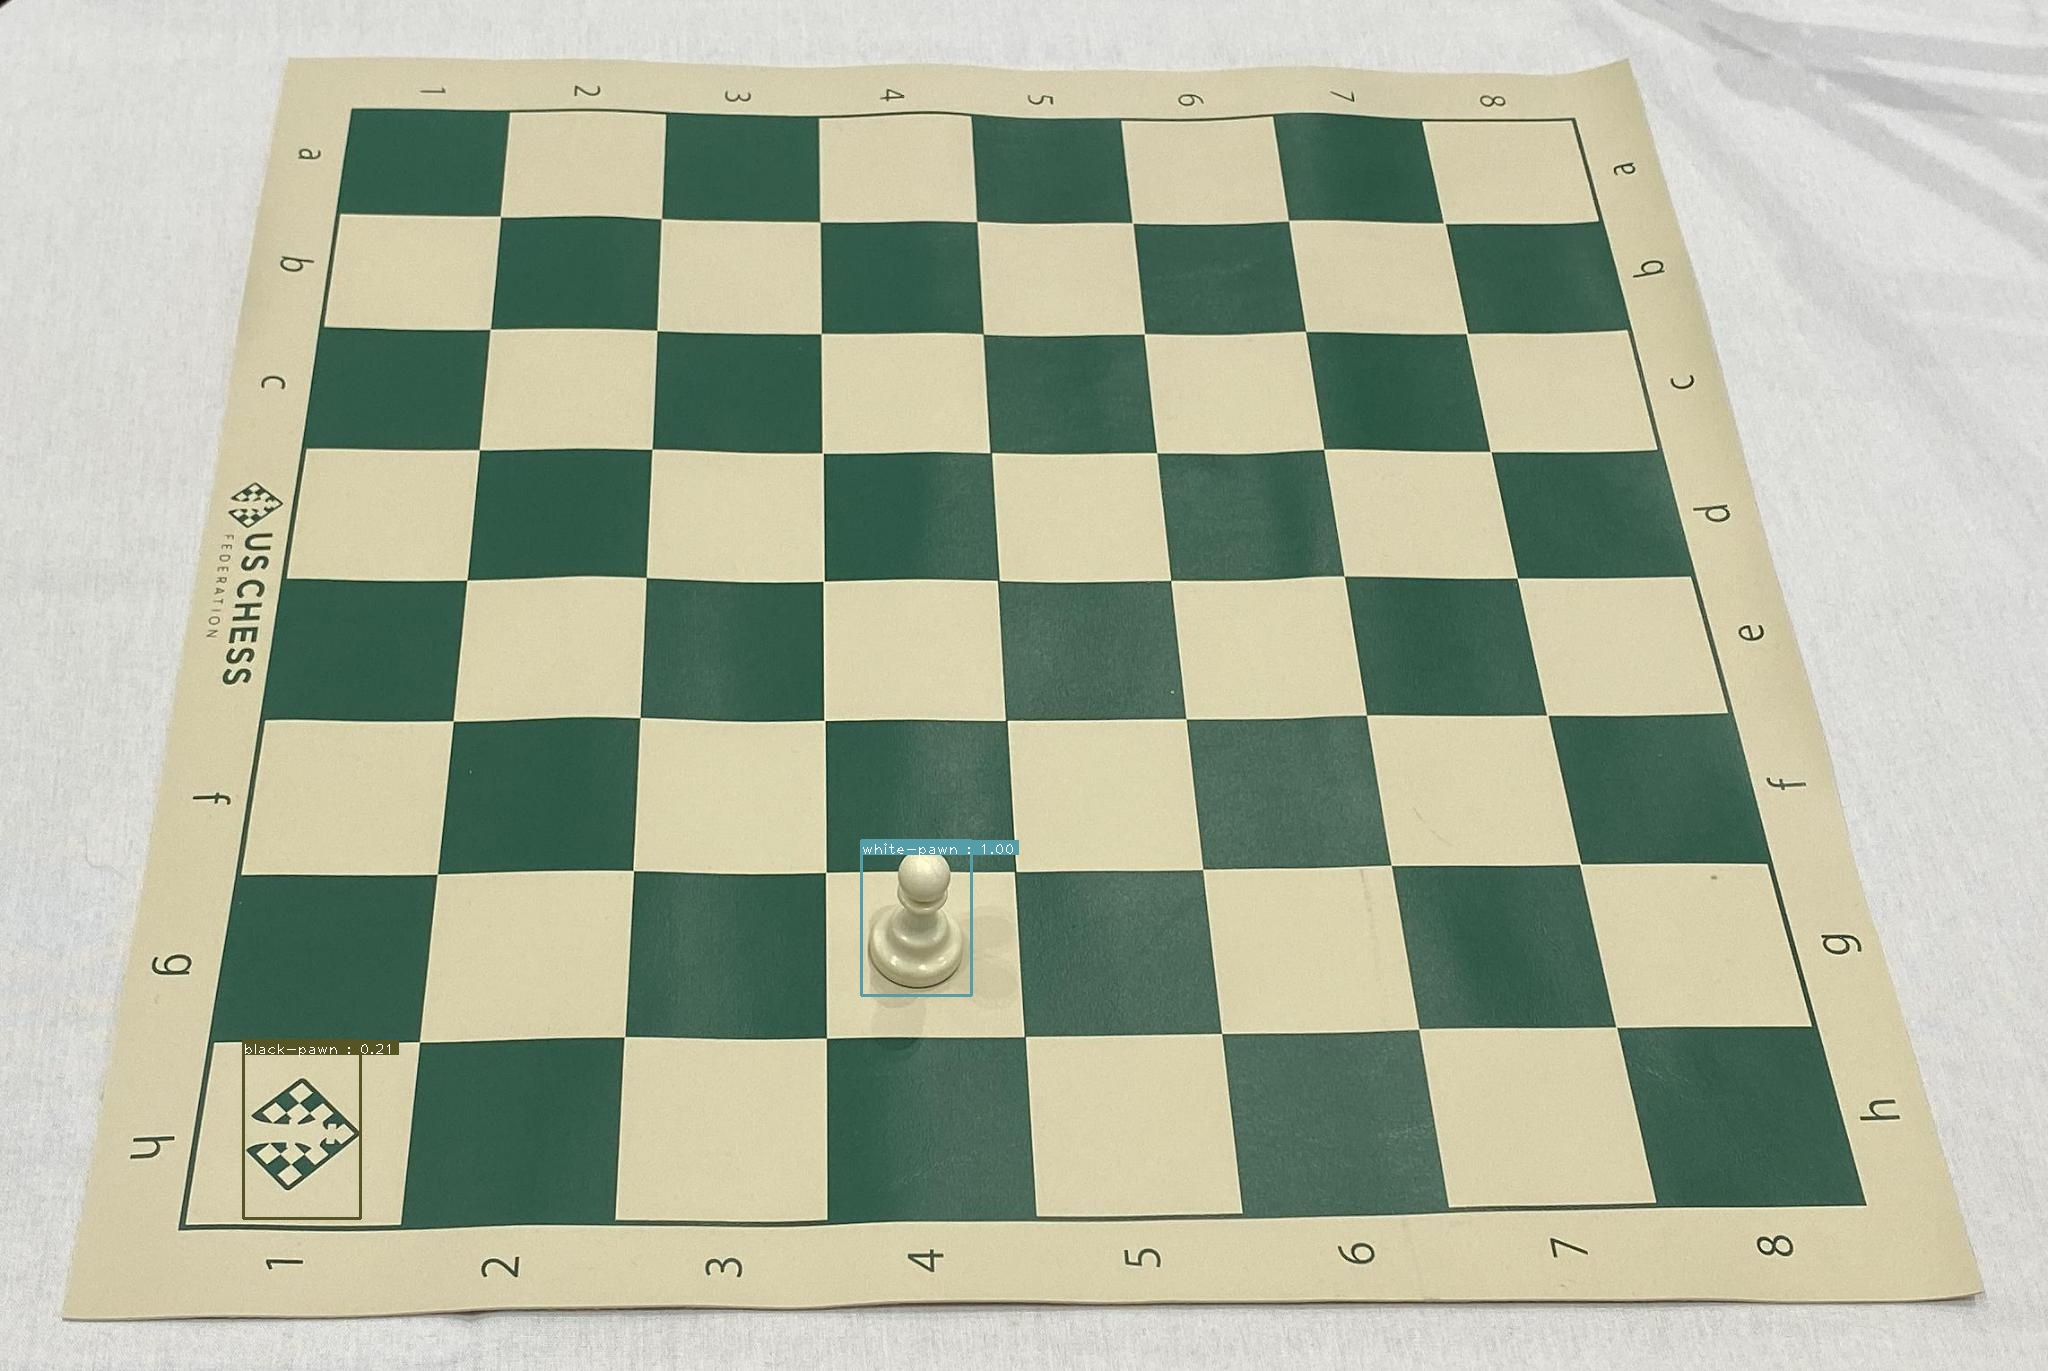

In [ ]:
from IPython.display import Image
Image(filename='output.jpg') 